In [134]:
import os
import sys
sys.path.append("../")
from models.unet import UNetDiffusion, UNet_diffusion_normal, UNet_diffusion_sample, UNet_diffusion_mixednormal
from data.datasets import PDE1D
import torch
from models.diffusion import Diffusion, generate_diffusion_samples_low_dimensional, DistributionalDiffusion
import matplotlib.pyplot as plt
import numpy as np

device = "cuda"

In [135]:
test_dataset = PDE1D(
    data_dir="../data/",
    pde="Burgers",
    var="test",
    downscaling_factor=4,
    normalize=True,
    last_t_steps=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=True,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
grid = test_dataset.get_coordinates()[0]

In [136]:
n_samples = 50
cfg_scale = 0
x_T_sampling_method="standard"
n_timesteps = 50

In [137]:
def plot_predictions(input, target, pred, grid, last_t_timesteps = 2):
    fig, axs = plt.subplots(3, 3, figsize=(18, 8))

    input_last_t = input[:,last_t_timesteps-1].cpu()
    mean_prediction = pred[:,0].mean(axis = -1).cpu()
    pred = pred.cpu()
    target = target.cpu()
    for i in range(3):
        axs[i,0].plot(grid, input_last_t[i].numpy())

        for j in range(n_samples):
            axs[i,1].plot(grid, (pred[i,0,:,j]+input_last_t[i]).numpy(), alpha=0.2, color="grey")
        axs[i,1].plot(grid, (target[i,0]+input_last_t[i]).numpy())
        axs[i,1].plot(grid, (mean_prediction[i]+input_last_t[i]).numpy(), label="Mean prediction", linestyle = "dashed")
        axs[i,1].set_ylim([(mean_prediction[i]+input_last_t[i]).min()-0.2, (mean_prediction[i]+input_last_t[i]).max()+0.2])


        for j in range(n_samples):
            axs[i,2].plot(grid, pred[i,0,:,j].numpy(), alpha=0.2, color="grey")
        axs[i,2].plot(grid, target[i,0].numpy(), label = "Truth")
        axs[i,2].plot(grid, mean_prediction[i].numpy(), label="Mean prediction", linestyle = "dashed")
        axs[i,2].set_ylim([mean_prediction[i].min()-0.2, mean_prediction[i].max()+0.2])

        axs[i,2].legend()


    axs[0,2].set_title("Residual prediction")
    axs[0,1].set_title("Original scale prediction")
    axs[0,0].set_title("Input")

# Deterministic

In [138]:
ckpt_path = "../results/20250709_085248_debug/Datetime_20250709_085248_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "deterministic"

In [139]:
model =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)

/tmp/ipykernel_1212138/1995388319.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [140]:
for batch in test_loader:
    target, input = batch
    target = target.to(device)
    input = input.to(device)
    
    pred = generate_diffusion_samples_low_dimensional(
        model=model,
        input = input,
        n_timesteps = n_timesteps,
        target_shape=target.shape,
        n_samples=n_samples,
        distributional_method=distributional_method,
        x_T_sampling_method=x_T_sampling_method,
        cfg_scale=cfg_scale,
        noise_schedule="linear",
    )

    break

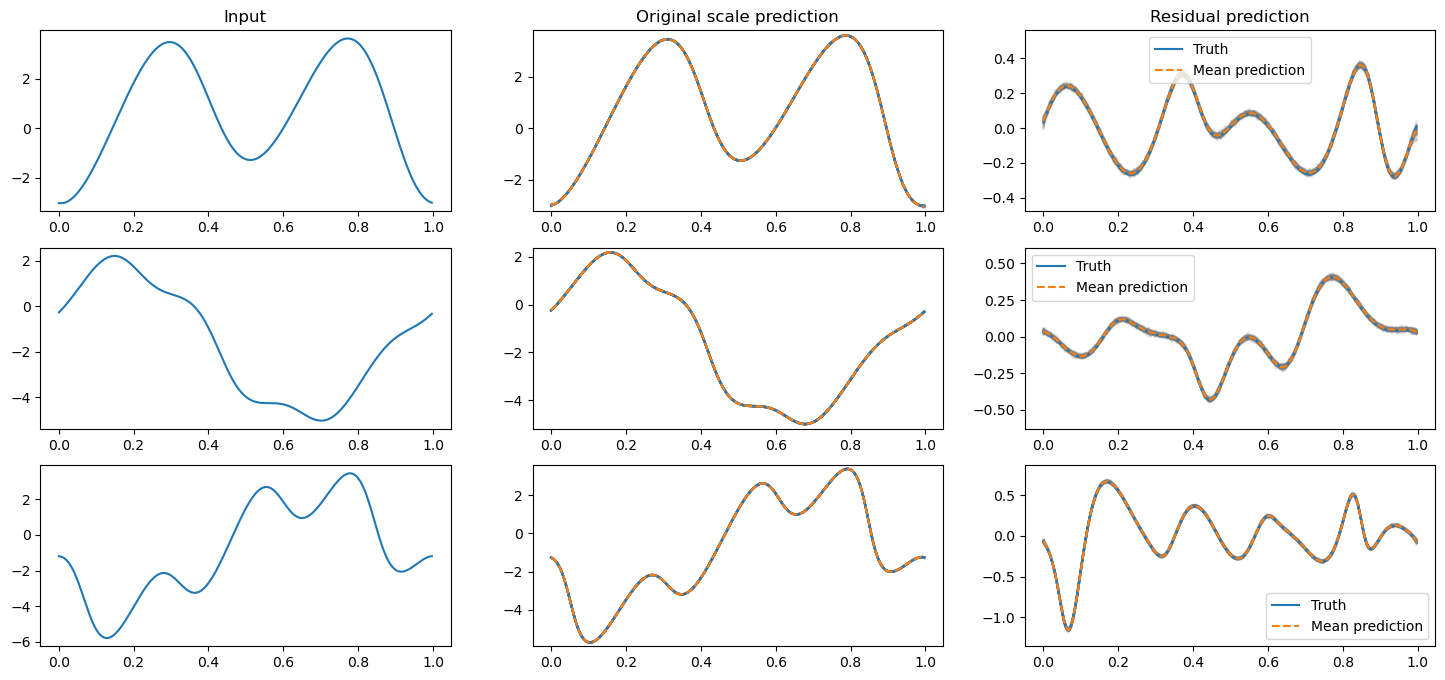

In [141]:
plot_predictions(input, target, pred, grid)

In [142]:
t_steps = 10
autoregressive_input = input.clone()
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)

for t in range(t_steps):
    pred = generate_diffusion_samples_low_dimensional(
        model=model,
        input = autoregressive_input,
        n_timesteps=n_timesteps,
        target_shape=target.shape,
        n_samples=1,
        distributional_method=distributional_method,
        x_T_sampling_method=x_T_sampling_method,
        cfg_scale=cfg_scale,
        noise_schedule="linear",
    )
    if t == 0:
        pred_array[...,t] = pred.squeeze(-1) + t0
    else:
        pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

    if t == 1:
        autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
    elif t > 1:
        autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)

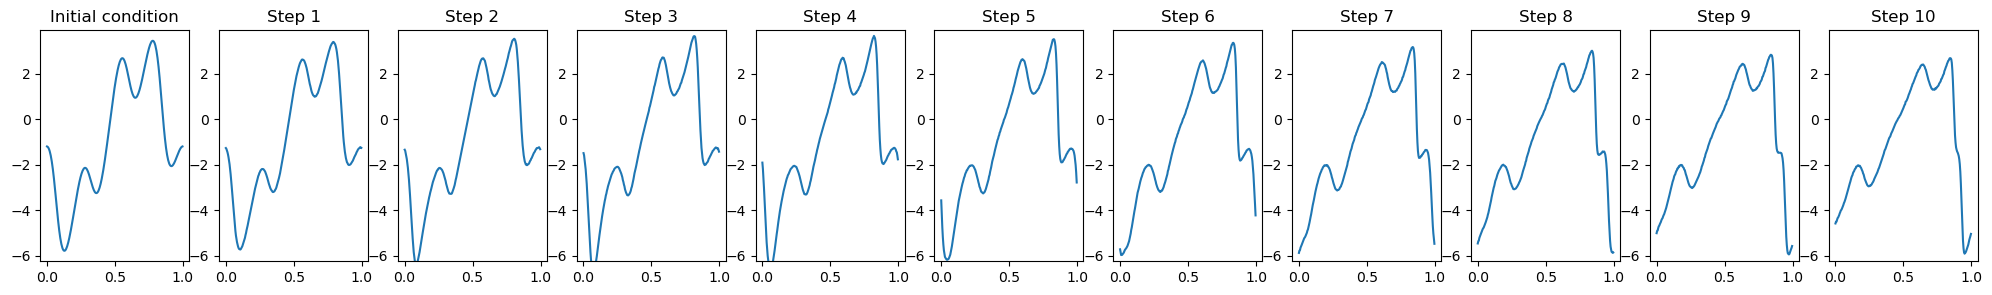

In [143]:
# Plot the autoregressive predictions
fig, axs = plt.subplots(1, t_steps+1, figsize=(25, 3))
b = np.random.randint(3)

axs[0].plot(grid, t0[b,0].cpu().numpy())
axs[0].set_title("Initial condition")
ylim = axs[0].get_ylim()
for t in range(t_steps):
    pred_plot = pred_array[b, 0, :, t]
    axs[t+1].plot(grid, pred_plot.cpu().numpy())
    axs[t+1].set_title(f"Step {t+1}")
    axs[t+1].set_ylim(ylim)

# Normal

In [144]:
ckpt_path = "../results/20250708_144800_debug/Datetime_20250708_144801_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "normal"

In [145]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=1,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_1212138/3274195715.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [146]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

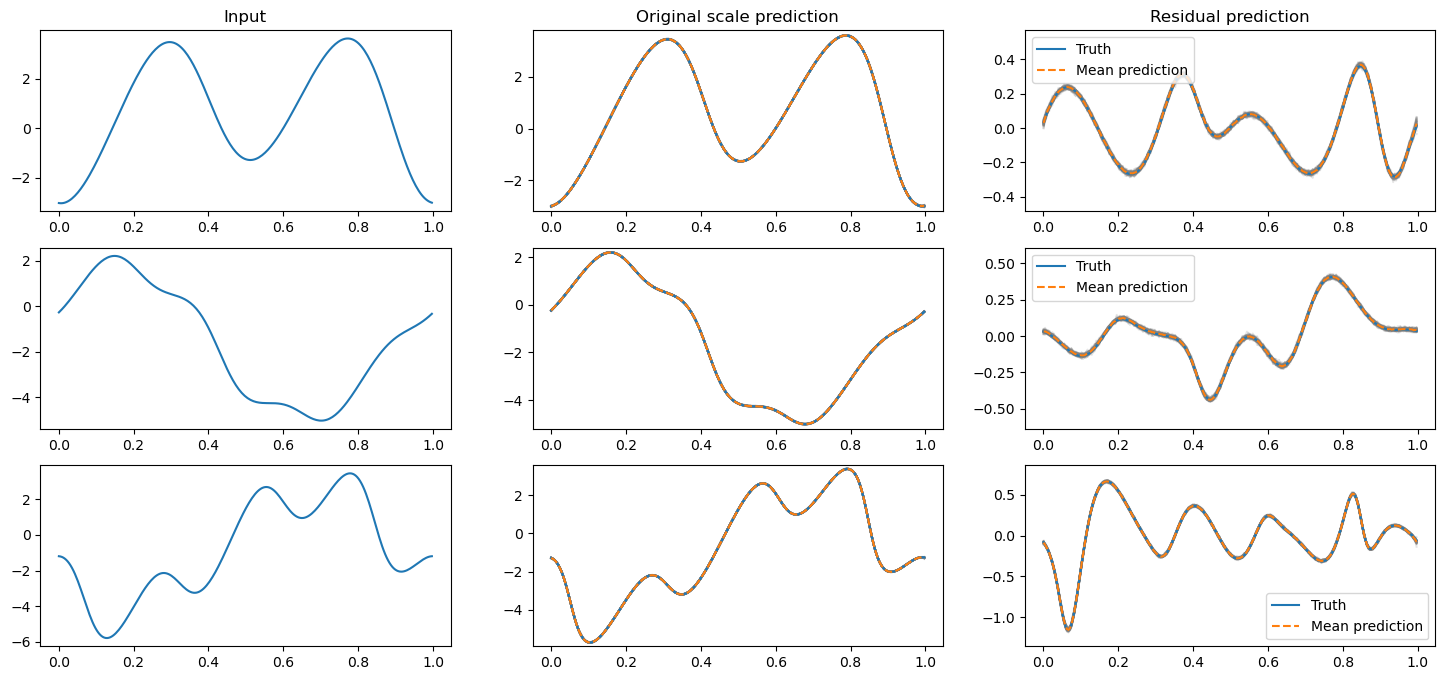

In [147]:
plot_predictions(input, target, pred, grid)

In [148]:
diffusion = DistributionalDiffusion(
    img_size=target.shape[1:], device=device, distributional_method=distributional_method, x_T_sampling_method=x_T_sampling_method
)
x = diffusion.sample_x_T((target.shape[0], *target_dim), pred)
t = (torch.ones(target.shape[0]) * 1000).long().to(device)
predicted_noise = model(x, t, input, pred = pred)

In [149]:
predicted_noise[0,0,0]

tensor([4.7292, 0.2784], device='cuda:0', grad_fn=<SelectBackward0>)

In [150]:
t_steps = 10
autoregressive_input = input.clone()
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)

for t in range(t_steps):
    pred = generate_diffusion_samples_low_dimensional(
        model=model,
        input = autoregressive_input,
        n_timesteps=n_timesteps,
        target_shape=target.shape,
        n_samples=1,
        distributional_method=distributional_method,
        x_T_sampling_method=x_T_sampling_method,
        cfg_scale=cfg_scale,
        noise_schedule="linear",
    )
    if t == 0:
        pred_array[...,t] = pred.squeeze(-1) + t0
    else:
        pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

    if t == 1:
        autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
    elif t > 1:
        autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)

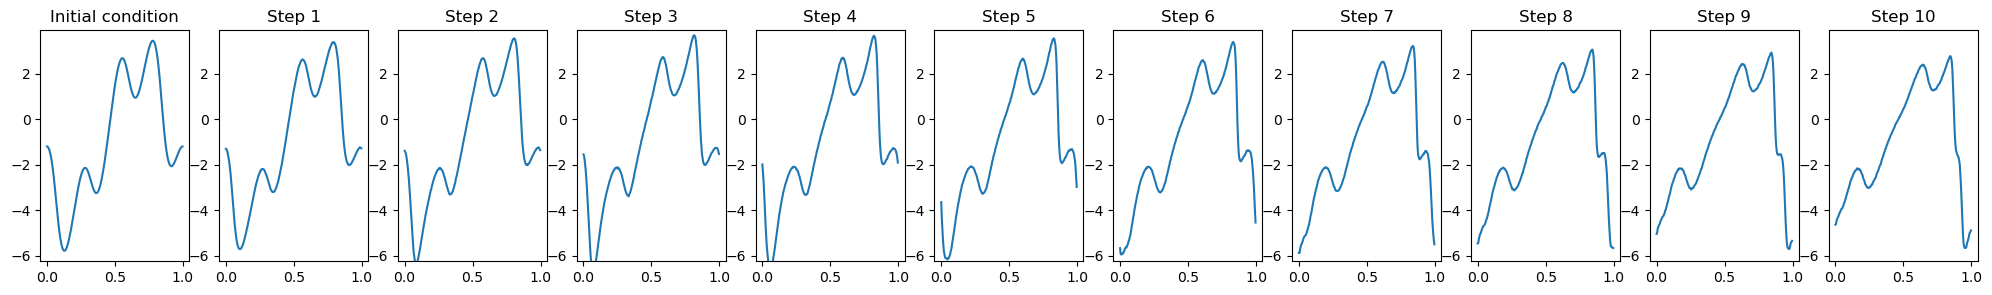

In [151]:
# Plot the autoregressive predictions
fig, axs = plt.subplots(1, t_steps+1, figsize=(25, 3))
b = np.random.randint(3)

axs[0].plot(grid, t0[b,0].cpu().numpy())
axs[0].set_title("Initial condition")
ylim = axs[0].get_ylim()
for t in range(t_steps):
    pred_plot = pred_array[b, 0, :, t]
    axs[t+1].plot(grid, pred_plot.cpu().numpy())
    axs[t+1].set_title(f"Step {t+1}")
    axs[t+1].set_ylim(ylim)

# Mixed normal

In [152]:
ckpt_path = "../results/20250708_144800_debug/Datetime_20250708_184548_Loss_1D_Burgers_UNet_diffusion_.pt"
distributional_method = "mixednormal"

In [153]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )

model = UNet_diffusion_mixednormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    n_components=10,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_1212138/952606495.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [154]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

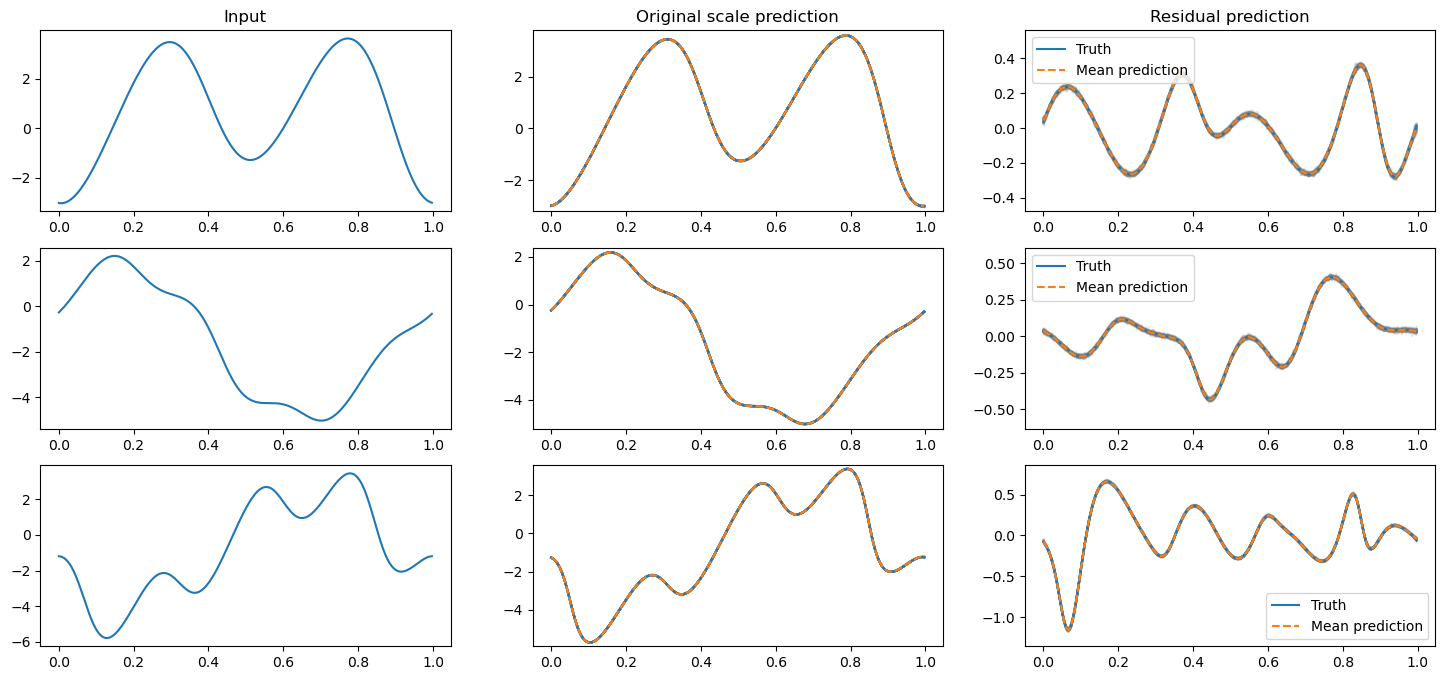

In [155]:
plot_predictions(input, target, pred, grid)

In [156]:
diffusion = DistributionalDiffusion(
    img_size=target.shape[1:], device=device, distributional_method=distributional_method, x_T_sampling_method=x_T_sampling_method
)
x = diffusion.sample_x_T((target.shape[0], *target_dim), pred)
t = (torch.ones(target.shape[0]) * 1000).long().to(device)
predicted_noise = model(x, t, input, pred = pred)

In [157]:
predicted_noise[0,0,0]

tensor([[6.2405e+00, 1.5229e-01, 9.4307e-01],
        [6.7004e+00, 1.8943e-01, 5.3452e-02],
        [5.8711e+00, 2.1340e-02, 1.6983e-07],
        [5.6262e+00, 3.3665e-02, 9.0900e-09],
        [5.7406e+00, 8.9046e-02, 1.2446e-05],
        [7.5951e+00, 7.5691e-02, 1.3137e-04],
        [5.9752e+00, 3.2510e-02, 6.6715e-05],
        [5.8713e+00, 1.0906e-01, 2.5276e-12],
        [6.0276e+00, 1.7096e-01, 3.0943e-03],
        [5.9409e+00, 7.3011e-02, 1.7075e-04]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [158]:
t_steps = 10
autoregressive_input = input.clone()
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)

for t in range(t_steps):
    pred = generate_diffusion_samples_low_dimensional(
        model=model,
        input = autoregressive_input,
        n_timesteps=n_timesteps,
        target_shape=target.shape,
        n_samples=1,
        distributional_method=distributional_method,
        x_T_sampling_method=x_T_sampling_method,
        cfg_scale=cfg_scale,
        noise_schedule="linear",
    )
    if t == 0:
        pred_array[...,t] = pred.squeeze(-1) + t0
    else:
        pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

    if t == 1:
        autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
    elif t > 1:
        autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)

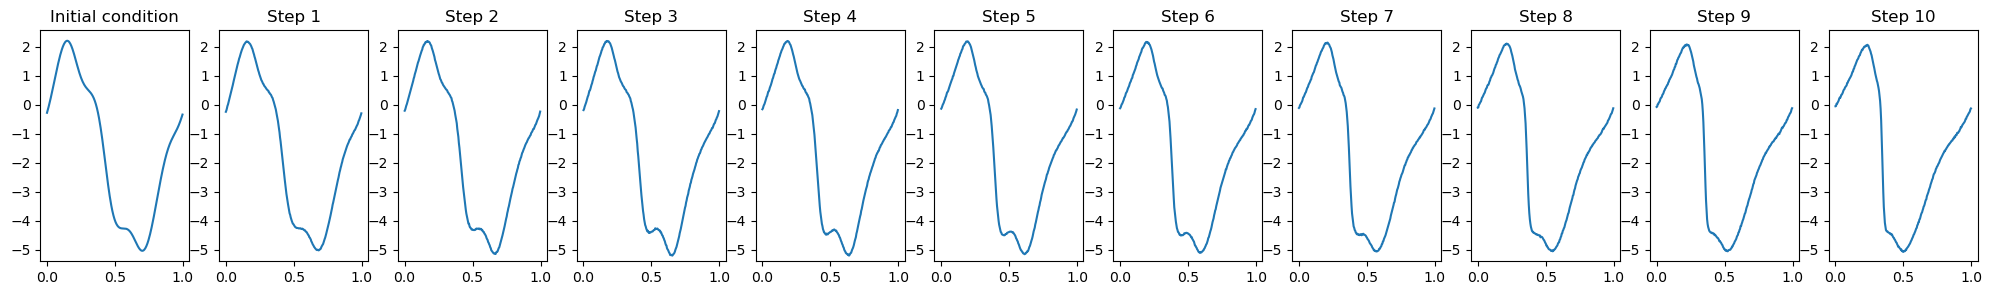

In [159]:
# Plot the autoregressive predictions
fig, axs = plt.subplots(1, t_steps+1, figsize=(25, 3))
b = np.random.randint(3)

axs[0].plot(grid, t0[b,0].cpu().numpy())
axs[0].set_title("Initial condition")
ylim = axs[0].get_ylim()
for t in range(t_steps):
    pred_plot = pred_array[b, 0, :, t]
    axs[t+1].plot(grid, pred_plot.cpu().numpy())
    axs[t+1].set_title(f"Step {t+1}")
    axs[t+1].set_ylim(ylim)

# Sample

In [160]:
ckpt_path = "../results/20250703_171143_debug/Datetime_20250704_070303_Loss_1D_Advection_UNet_diffusion_.pt"
distributional_method = "sample"

In [161]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=16,
            in_channels=1,
            out_channels=1,
            init_features=32,
        )

model = UNet_diffusion_sample(
    backbone=backbone,
    d=1,
    target_dim = 1,
    hidden_dim=16
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_1212138/587999794.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


RuntimeError: Error(s) in loading state_dict for UNet_diffusion_sample:
	Missing key(s) in state_dict: "backbone.unet.map_noise.freqs", "backbone.unet.map_layer0.weight", "backbone.unet.map_layer0.bias", "backbone.unet.map_layer1.weight", "backbone.unet.map_layer1.bias", "backbone.unet.enc.128x128_conv.weight", "backbone.unet.enc.128x128_conv.bias", "backbone.unet.enc.128x128_block0.norm0.weight", "backbone.unet.enc.128x128_block0.norm0.bias", "backbone.unet.enc.128x128_block0.conv0.weight", "backbone.unet.enc.128x128_block0.conv0.bias", "backbone.unet.enc.128x128_block0.affine.weight", "backbone.unet.enc.128x128_block0.affine.bias", "backbone.unet.enc.128x128_block0.norm1.weight", "backbone.unet.enc.128x128_block0.norm1.bias", "backbone.unet.enc.128x128_block0.conv1.weight", "backbone.unet.enc.128x128_block0.conv1.bias", "backbone.unet.enc.128x128_block1.norm0.weight", "backbone.unet.enc.128x128_block1.norm0.bias", "backbone.unet.enc.128x128_block1.conv0.weight", "backbone.unet.enc.128x128_block1.conv0.bias", "backbone.unet.enc.128x128_block1.affine.weight", "backbone.unet.enc.128x128_block1.affine.bias", "backbone.unet.enc.128x128_block1.norm1.weight", "backbone.unet.enc.128x128_block1.norm1.bias", "backbone.unet.enc.128x128_block1.conv1.weight", "backbone.unet.enc.128x128_block1.conv1.bias", "backbone.unet.enc.128x128_block2.norm0.weight", "backbone.unet.enc.128x128_block2.norm0.bias", "backbone.unet.enc.128x128_block2.conv0.weight", "backbone.unet.enc.128x128_block2.conv0.bias", "backbone.unet.enc.128x128_block2.affine.weight", "backbone.unet.enc.128x128_block2.affine.bias", "backbone.unet.enc.128x128_block2.norm1.weight", "backbone.unet.enc.128x128_block2.norm1.bias", "backbone.unet.enc.128x128_block2.conv1.weight", "backbone.unet.enc.128x128_block2.conv1.bias", "backbone.unet.enc.128x128_block3.norm0.weight", "backbone.unet.enc.128x128_block3.norm0.bias", "backbone.unet.enc.128x128_block3.conv0.weight", "backbone.unet.enc.128x128_block3.conv0.bias", "backbone.unet.enc.128x128_block3.affine.weight", "backbone.unet.enc.128x128_block3.affine.bias", "backbone.unet.enc.128x128_block3.norm1.weight", "backbone.unet.enc.128x128_block3.norm1.bias", "backbone.unet.enc.128x128_block3.conv1.weight", "backbone.unet.enc.128x128_block3.conv1.bias", "backbone.unet.enc.64x64_down.norm0.weight", "backbone.unet.enc.64x64_down.norm0.bias", "backbone.unet.enc.64x64_down.conv0.weight", "backbone.unet.enc.64x64_down.conv0.bias", "backbone.unet.enc.64x64_down.conv0.resample_filter", "backbone.unet.enc.64x64_down.affine.weight", "backbone.unet.enc.64x64_down.affine.bias", "backbone.unet.enc.64x64_down.norm1.weight", "backbone.unet.enc.64x64_down.norm1.bias", "backbone.unet.enc.64x64_down.conv1.weight", "backbone.unet.enc.64x64_down.conv1.bias", "backbone.unet.enc.64x64_down.skip.weight", "backbone.unet.enc.64x64_down.skip.bias", "backbone.unet.enc.64x64_down.skip.resample_filter", "backbone.unet.enc.64x64_block0.norm0.weight", "backbone.unet.enc.64x64_block0.norm0.bias", "backbone.unet.enc.64x64_block0.conv0.weight", "backbone.unet.enc.64x64_block0.conv0.bias", "backbone.unet.enc.64x64_block0.affine.weight", "backbone.unet.enc.64x64_block0.affine.bias", "backbone.unet.enc.64x64_block0.norm1.weight", "backbone.unet.enc.64x64_block0.norm1.bias", "backbone.unet.enc.64x64_block0.conv1.weight", "backbone.unet.enc.64x64_block0.conv1.bias", "backbone.unet.enc.64x64_block0.skip.weight", "backbone.unet.enc.64x64_block0.skip.bias", "backbone.unet.enc.64x64_block1.norm0.weight", "backbone.unet.enc.64x64_block1.norm0.bias", "backbone.unet.enc.64x64_block1.conv0.weight", "backbone.unet.enc.64x64_block1.conv0.bias", "backbone.unet.enc.64x64_block1.affine.weight", "backbone.unet.enc.64x64_block1.affine.bias", "backbone.unet.enc.64x64_block1.norm1.weight", "backbone.unet.enc.64x64_block1.norm1.bias", "backbone.unet.enc.64x64_block1.conv1.weight", "backbone.unet.enc.64x64_block1.conv1.bias", "backbone.unet.enc.64x64_block2.norm0.weight", "backbone.unet.enc.64x64_block2.norm0.bias", "backbone.unet.enc.64x64_block2.conv0.weight", "backbone.unet.enc.64x64_block2.conv0.bias", "backbone.unet.enc.64x64_block2.affine.weight", "backbone.unet.enc.64x64_block2.affine.bias", "backbone.unet.enc.64x64_block2.norm1.weight", "backbone.unet.enc.64x64_block2.norm1.bias", "backbone.unet.enc.64x64_block2.conv1.weight", "backbone.unet.enc.64x64_block2.conv1.bias", "backbone.unet.enc.64x64_block3.norm0.weight", "backbone.unet.enc.64x64_block3.norm0.bias", "backbone.unet.enc.64x64_block3.conv0.weight", "backbone.unet.enc.64x64_block3.conv0.bias", "backbone.unet.enc.64x64_block3.affine.weight", "backbone.unet.enc.64x64_block3.affine.bias", "backbone.unet.enc.64x64_block3.norm1.weight", "backbone.unet.enc.64x64_block3.norm1.bias", "backbone.unet.enc.64x64_block3.conv1.weight", "backbone.unet.enc.64x64_block3.conv1.bias", "backbone.unet.enc.32x32_down.norm0.weight", "backbone.unet.enc.32x32_down.norm0.bias", "backbone.unet.enc.32x32_down.conv0.weight", "backbone.unet.enc.32x32_down.conv0.bias", "backbone.unet.enc.32x32_down.conv0.resample_filter", "backbone.unet.enc.32x32_down.affine.weight", "backbone.unet.enc.32x32_down.affine.bias", "backbone.unet.enc.32x32_down.norm1.weight", "backbone.unet.enc.32x32_down.norm1.bias", "backbone.unet.enc.32x32_down.conv1.weight", "backbone.unet.enc.32x32_down.conv1.bias", "backbone.unet.enc.32x32_down.skip.weight", "backbone.unet.enc.32x32_down.skip.bias", "backbone.unet.enc.32x32_down.skip.resample_filter", "backbone.unet.enc.32x32_block0.norm0.weight", "backbone.unet.enc.32x32_block0.norm0.bias", "backbone.unet.enc.32x32_block0.conv0.weight", "backbone.unet.enc.32x32_block0.conv0.bias", "backbone.unet.enc.32x32_block0.affine.weight", "backbone.unet.enc.32x32_block0.affine.bias", "backbone.unet.enc.32x32_block0.norm1.weight", "backbone.unet.enc.32x32_block0.norm1.bias", "backbone.unet.enc.32x32_block0.conv1.weight", "backbone.unet.enc.32x32_block0.conv1.bias", "backbone.unet.enc.32x32_block1.norm0.weight", "backbone.unet.enc.32x32_block1.norm0.bias", "backbone.unet.enc.32x32_block1.conv0.weight", "backbone.unet.enc.32x32_block1.conv0.bias", "backbone.unet.enc.32x32_block1.affine.weight", "backbone.unet.enc.32x32_block1.affine.bias", "backbone.unet.enc.32x32_block1.norm1.weight", "backbone.unet.enc.32x32_block1.norm1.bias", "backbone.unet.enc.32x32_block1.conv1.weight", "backbone.unet.enc.32x32_block1.conv1.bias", "backbone.unet.enc.32x32_block2.norm0.weight", "backbone.unet.enc.32x32_block2.norm0.bias", "backbone.unet.enc.32x32_block2.conv0.weight", "backbone.unet.enc.32x32_block2.conv0.bias", "backbone.unet.enc.32x32_block2.affine.weight", "backbone.unet.enc.32x32_block2.affine.bias", "backbone.unet.enc.32x32_block2.norm1.weight", "backbone.unet.enc.32x32_block2.norm1.bias", "backbone.unet.enc.32x32_block2.conv1.weight", "backbone.unet.enc.32x32_block2.conv1.bias", "backbone.unet.enc.32x32_block3.norm0.weight", "backbone.unet.enc.32x32_block3.norm0.bias", "backbone.unet.enc.32x32_block3.conv0.weight", "backbone.unet.enc.32x32_block3.conv0.bias", "backbone.unet.enc.32x32_block3.affine.weight", "backbone.unet.enc.32x32_block3.affine.bias", "backbone.unet.enc.32x32_block3.norm1.weight", "backbone.unet.enc.32x32_block3.norm1.bias", "backbone.unet.enc.32x32_block3.conv1.weight", "backbone.unet.enc.32x32_block3.conv1.bias", "backbone.unet.enc.16x16_down.norm0.weight", "backbone.unet.enc.16x16_down.norm0.bias", "backbone.unet.enc.16x16_down.conv0.weight", "backbone.unet.enc.16x16_down.conv0.bias", "backbone.unet.enc.16x16_down.conv0.resample_filter", "backbone.unet.enc.16x16_down.affine.weight", "backbone.unet.enc.16x16_down.affine.bias", "backbone.unet.enc.16x16_down.norm1.weight", "backbone.unet.enc.16x16_down.norm1.bias", "backbone.unet.enc.16x16_down.conv1.weight", "backbone.unet.enc.16x16_down.conv1.bias", "backbone.unet.enc.16x16_down.skip.weight", "backbone.unet.enc.16x16_down.skip.bias", "backbone.unet.enc.16x16_down.skip.resample_filter", "backbone.unet.enc.16x16_block0.norm0.weight", "backbone.unet.enc.16x16_block0.norm0.bias", "backbone.unet.enc.16x16_block0.conv0.weight", "backbone.unet.enc.16x16_block0.conv0.bias", "backbone.unet.enc.16x16_block0.affine.weight", "backbone.unet.enc.16x16_block0.affine.bias", "backbone.unet.enc.16x16_block0.norm1.weight", "backbone.unet.enc.16x16_block0.norm1.bias", "backbone.unet.enc.16x16_block0.conv1.weight", "backbone.unet.enc.16x16_block0.conv1.bias", "backbone.unet.enc.16x16_block0.norm2.weight", "backbone.unet.enc.16x16_block0.norm2.bias", "backbone.unet.enc.16x16_block0.qkv.weight", "backbone.unet.enc.16x16_block0.qkv.bias", "backbone.unet.enc.16x16_block0.proj.weight", "backbone.unet.enc.16x16_block0.proj.bias", "backbone.unet.enc.16x16_block1.norm0.weight", "backbone.unet.enc.16x16_block1.norm0.bias", "backbone.unet.enc.16x16_block1.conv0.weight", "backbone.unet.enc.16x16_block1.conv0.bias", "backbone.unet.enc.16x16_block1.affine.weight", "backbone.unet.enc.16x16_block1.affine.bias", "backbone.unet.enc.16x16_block1.norm1.weight", "backbone.unet.enc.16x16_block1.norm1.bias", "backbone.unet.enc.16x16_block1.conv1.weight", "backbone.unet.enc.16x16_block1.conv1.bias", "backbone.unet.enc.16x16_block1.norm2.weight", "backbone.unet.enc.16x16_block1.norm2.bias", "backbone.unet.enc.16x16_block1.qkv.weight", "backbone.unet.enc.16x16_block1.qkv.bias", "backbone.unet.enc.16x16_block1.proj.weight", "backbone.unet.enc.16x16_block1.proj.bias", "backbone.unet.enc.16x16_block2.norm0.weight", "backbone.unet.enc.16x16_block2.norm0.bias", "backbone.unet.enc.16x16_block2.conv0.weight", "backbone.unet.enc.16x16_block2.conv0.bias", "backbone.unet.enc.16x16_block2.affine.weight", "backbone.unet.enc.16x16_block2.affine.bias", "backbone.unet.enc.16x16_block2.norm1.weight", "backbone.unet.enc.16x16_block2.norm1.bias", "backbone.unet.enc.16x16_block2.conv1.weight", "backbone.unet.enc.16x16_block2.conv1.bias", "backbone.unet.enc.16x16_block2.norm2.weight", "backbone.unet.enc.16x16_block2.norm2.bias", "backbone.unet.enc.16x16_block2.qkv.weight", "backbone.unet.enc.16x16_block2.qkv.bias", "backbone.unet.enc.16x16_block2.proj.weight", "backbone.unet.enc.16x16_block2.proj.bias", "backbone.unet.enc.16x16_block3.norm0.weight", "backbone.unet.enc.16x16_block3.norm0.bias", "backbone.unet.enc.16x16_block3.conv0.weight", "backbone.unet.enc.16x16_block3.conv0.bias", "backbone.unet.enc.16x16_block3.affine.weight", "backbone.unet.enc.16x16_block3.affine.bias", "backbone.unet.enc.16x16_block3.norm1.weight", "backbone.unet.enc.16x16_block3.norm1.bias", "backbone.unet.enc.16x16_block3.conv1.weight", "backbone.unet.enc.16x16_block3.conv1.bias", "backbone.unet.enc.16x16_block3.norm2.weight", "backbone.unet.enc.16x16_block3.norm2.bias", "backbone.unet.enc.16x16_block3.qkv.weight", "backbone.unet.enc.16x16_block3.qkv.bias", "backbone.unet.enc.16x16_block3.proj.weight", "backbone.unet.enc.16x16_block3.proj.bias", "backbone.unet.dec.16x16_in0.norm0.weight", "backbone.unet.dec.16x16_in0.norm0.bias", "backbone.unet.dec.16x16_in0.conv0.weight", "backbone.unet.dec.16x16_in0.conv0.bias", "backbone.unet.dec.16x16_in0.affine.weight", "backbone.unet.dec.16x16_in0.affine.bias", "backbone.unet.dec.16x16_in0.norm1.weight", "backbone.unet.dec.16x16_in0.norm1.bias", "backbone.unet.dec.16x16_in0.conv1.weight", "backbone.unet.dec.16x16_in0.conv1.bias", "backbone.unet.dec.16x16_in0.norm2.weight", "backbone.unet.dec.16x16_in0.norm2.bias", "backbone.unet.dec.16x16_in0.qkv.weight", "backbone.unet.dec.16x16_in0.qkv.bias", "backbone.unet.dec.16x16_in0.proj.weight", "backbone.unet.dec.16x16_in0.proj.bias", "backbone.unet.dec.16x16_in1.norm0.weight", "backbone.unet.dec.16x16_in1.norm0.bias", "backbone.unet.dec.16x16_in1.conv0.weight", "backbone.unet.dec.16x16_in1.conv0.bias", "backbone.unet.dec.16x16_in1.affine.weight", "backbone.unet.dec.16x16_in1.affine.bias", "backbone.unet.dec.16x16_in1.norm1.weight", "backbone.unet.dec.16x16_in1.norm1.bias", "backbone.unet.dec.16x16_in1.conv1.weight", "backbone.unet.dec.16x16_in1.conv1.bias", "backbone.unet.dec.16x16_block0.norm0.weight", "backbone.unet.dec.16x16_block0.norm0.bias", "backbone.unet.dec.16x16_block0.conv0.weight", "backbone.unet.dec.16x16_block0.conv0.bias", "backbone.unet.dec.16x16_block0.affine.weight", "backbone.unet.dec.16x16_block0.affine.bias", "backbone.unet.dec.16x16_block0.norm1.weight", "backbone.unet.dec.16x16_block0.norm1.bias", "backbone.unet.dec.16x16_block0.conv1.weight", "backbone.unet.dec.16x16_block0.conv1.bias", "backbone.unet.dec.16x16_block0.skip.weight", "backbone.unet.dec.16x16_block0.skip.bias", "backbone.unet.dec.16x16_block1.norm0.weight", "backbone.unet.dec.16x16_block1.norm0.bias", "backbone.unet.dec.16x16_block1.conv0.weight", "backbone.unet.dec.16x16_block1.conv0.bias", "backbone.unet.dec.16x16_block1.affine.weight", "backbone.unet.dec.16x16_block1.affine.bias", "backbone.unet.dec.16x16_block1.norm1.weight", "backbone.unet.dec.16x16_block1.norm1.bias", "backbone.unet.dec.16x16_block1.conv1.weight", "backbone.unet.dec.16x16_block1.conv1.bias", "backbone.unet.dec.16x16_block1.skip.weight", "backbone.unet.dec.16x16_block1.skip.bias", "backbone.unet.dec.16x16_block2.norm0.weight", "backbone.unet.dec.16x16_block2.norm0.bias", "backbone.unet.dec.16x16_block2.conv0.weight", "backbone.unet.dec.16x16_block2.conv0.bias", "backbone.unet.dec.16x16_block2.affine.weight", "backbone.unet.dec.16x16_block2.affine.bias", "backbone.unet.dec.16x16_block2.norm1.weight", "backbone.unet.dec.16x16_block2.norm1.bias", "backbone.unet.dec.16x16_block2.conv1.weight", "backbone.unet.dec.16x16_block2.conv1.bias", "backbone.unet.dec.16x16_block2.skip.weight", "backbone.unet.dec.16x16_block2.skip.bias", "backbone.unet.dec.16x16_block3.norm0.weight", "backbone.unet.dec.16x16_block3.norm0.bias", "backbone.unet.dec.16x16_block3.conv0.weight", "backbone.unet.dec.16x16_block3.conv0.bias", "backbone.unet.dec.16x16_block3.affine.weight", "backbone.unet.dec.16x16_block3.affine.bias", "backbone.unet.dec.16x16_block3.norm1.weight", "backbone.unet.dec.16x16_block3.norm1.bias", "backbone.unet.dec.16x16_block3.conv1.weight", "backbone.unet.dec.16x16_block3.conv1.bias", "backbone.unet.dec.16x16_block3.skip.weight", "backbone.unet.dec.16x16_block3.skip.bias", "backbone.unet.dec.16x16_block4.norm0.weight", "backbone.unet.dec.16x16_block4.norm0.bias", "backbone.unet.dec.16x16_block4.conv0.weight", "backbone.unet.dec.16x16_block4.conv0.bias", "backbone.unet.dec.16x16_block4.affine.weight", "backbone.unet.dec.16x16_block4.affine.bias", "backbone.unet.dec.16x16_block4.norm1.weight", "backbone.unet.dec.16x16_block4.norm1.bias", "backbone.unet.dec.16x16_block4.conv1.weight", "backbone.unet.dec.16x16_block4.conv1.bias", "backbone.unet.dec.16x16_block4.skip.weight", "backbone.unet.dec.16x16_block4.skip.bias", "backbone.unet.dec.16x16_block4.norm2.weight", "backbone.unet.dec.16x16_block4.norm2.bias", "backbone.unet.dec.16x16_block4.qkv.weight", "backbone.unet.dec.16x16_block4.qkv.bias", "backbone.unet.dec.16x16_block4.proj.weight", "backbone.unet.dec.16x16_block4.proj.bias", "backbone.unet.dec.32x32_up.norm0.weight", "backbone.unet.dec.32x32_up.norm0.bias", "backbone.unet.dec.32x32_up.conv0.weight", "backbone.unet.dec.32x32_up.conv0.bias", "backbone.unet.dec.32x32_up.conv0.resample_filter", "backbone.unet.dec.32x32_up.affine.weight", "backbone.unet.dec.32x32_up.affine.bias", "backbone.unet.dec.32x32_up.norm1.weight", "backbone.unet.dec.32x32_up.norm1.bias", "backbone.unet.dec.32x32_up.conv1.weight", "backbone.unet.dec.32x32_up.conv1.bias", "backbone.unet.dec.32x32_up.skip.weight", "backbone.unet.dec.32x32_up.skip.bias", "backbone.unet.dec.32x32_up.skip.resample_filter", "backbone.unet.dec.32x32_block0.norm0.weight", "backbone.unet.dec.32x32_block0.norm0.bias", "backbone.unet.dec.32x32_block0.conv0.weight", "backbone.unet.dec.32x32_block0.conv0.bias", "backbone.unet.dec.32x32_block0.affine.weight", "backbone.unet.dec.32x32_block0.affine.bias", "backbone.unet.dec.32x32_block0.norm1.weight", "backbone.unet.dec.32x32_block0.norm1.bias", "backbone.unet.dec.32x32_block0.conv1.weight", "backbone.unet.dec.32x32_block0.conv1.bias", "backbone.unet.dec.32x32_block0.skip.weight", "backbone.unet.dec.32x32_block0.skip.bias", "backbone.unet.dec.32x32_block1.norm0.weight", "backbone.unet.dec.32x32_block1.norm0.bias", "backbone.unet.dec.32x32_block1.conv0.weight", "backbone.unet.dec.32x32_block1.conv0.bias", "backbone.unet.dec.32x32_block1.affine.weight", "backbone.unet.dec.32x32_block1.affine.bias", "backbone.unet.dec.32x32_block1.norm1.weight", "backbone.unet.dec.32x32_block1.norm1.bias", "backbone.unet.dec.32x32_block1.conv1.weight", "backbone.unet.dec.32x32_block1.conv1.bias", "backbone.unet.dec.32x32_block1.skip.weight", "backbone.unet.dec.32x32_block1.skip.bias", "backbone.unet.dec.32x32_block2.norm0.weight", "backbone.unet.dec.32x32_block2.norm0.bias", "backbone.unet.dec.32x32_block2.conv0.weight", "backbone.unet.dec.32x32_block2.conv0.bias", "backbone.unet.dec.32x32_block2.affine.weight", "backbone.unet.dec.32x32_block2.affine.bias", "backbone.unet.dec.32x32_block2.norm1.weight", "backbone.unet.dec.32x32_block2.norm1.bias", "backbone.unet.dec.32x32_block2.conv1.weight", "backbone.unet.dec.32x32_block2.conv1.bias", "backbone.unet.dec.32x32_block2.skip.weight", "backbone.unet.dec.32x32_block2.skip.bias", "backbone.unet.dec.32x32_block3.norm0.weight", "backbone.unet.dec.32x32_block3.norm0.bias", "backbone.unet.dec.32x32_block3.conv0.weight", "backbone.unet.dec.32x32_block3.conv0.bias", "backbone.unet.dec.32x32_block3.affine.weight", "backbone.unet.dec.32x32_block3.affine.bias", "backbone.unet.dec.32x32_block3.norm1.weight", "backbone.unet.dec.32x32_block3.norm1.bias", "backbone.unet.dec.32x32_block3.conv1.weight", "backbone.unet.dec.32x32_block3.conv1.bias", "backbone.unet.dec.32x32_block3.skip.weight", "backbone.unet.dec.32x32_block3.skip.bias", "backbone.unet.dec.32x32_block4.norm0.weight", "backbone.unet.dec.32x32_block4.norm0.bias", "backbone.unet.dec.32x32_block4.conv0.weight", "backbone.unet.dec.32x32_block4.conv0.bias", "backbone.unet.dec.32x32_block4.affine.weight", "backbone.unet.dec.32x32_block4.affine.bias", "backbone.unet.dec.32x32_block4.norm1.weight", "backbone.unet.dec.32x32_block4.norm1.bias", "backbone.unet.dec.32x32_block4.conv1.weight", "backbone.unet.dec.32x32_block4.conv1.bias", "backbone.unet.dec.32x32_block4.skip.weight", "backbone.unet.dec.32x32_block4.skip.bias", "backbone.unet.dec.64x64_up.norm0.weight", "backbone.unet.dec.64x64_up.norm0.bias", "backbone.unet.dec.64x64_up.conv0.weight", "backbone.unet.dec.64x64_up.conv0.bias", "backbone.unet.dec.64x64_up.conv0.resample_filter", "backbone.unet.dec.64x64_up.affine.weight", "backbone.unet.dec.64x64_up.affine.bias", "backbone.unet.dec.64x64_up.norm1.weight", "backbone.unet.dec.64x64_up.norm1.bias", "backbone.unet.dec.64x64_up.conv1.weight", "backbone.unet.dec.64x64_up.conv1.bias", "backbone.unet.dec.64x64_up.skip.weight", "backbone.unet.dec.64x64_up.skip.bias", "backbone.unet.dec.64x64_up.skip.resample_filter", "backbone.unet.dec.64x64_block0.norm0.weight", "backbone.unet.dec.64x64_block0.norm0.bias", "backbone.unet.dec.64x64_block0.conv0.weight", "backbone.unet.dec.64x64_block0.conv0.bias", "backbone.unet.dec.64x64_block0.affine.weight", "backbone.unet.dec.64x64_block0.affine.bias", "backbone.unet.dec.64x64_block0.norm1.weight", "backbone.unet.dec.64x64_block0.norm1.bias", "backbone.unet.dec.64x64_block0.conv1.weight", "backbone.unet.dec.64x64_block0.conv1.bias", "backbone.unet.dec.64x64_block0.skip.weight", "backbone.unet.dec.64x64_block0.skip.bias", "backbone.unet.dec.64x64_block1.norm0.weight", "backbone.unet.dec.64x64_block1.norm0.bias", "backbone.unet.dec.64x64_block1.conv0.weight", "backbone.unet.dec.64x64_block1.conv0.bias", "backbone.unet.dec.64x64_block1.affine.weight", "backbone.unet.dec.64x64_block1.affine.bias", "backbone.unet.dec.64x64_block1.norm1.weight", "backbone.unet.dec.64x64_block1.norm1.bias", "backbone.unet.dec.64x64_block1.conv1.weight", "backbone.unet.dec.64x64_block1.conv1.bias", "backbone.unet.dec.64x64_block1.skip.weight", "backbone.unet.dec.64x64_block1.skip.bias", "backbone.unet.dec.64x64_block2.norm0.weight", "backbone.unet.dec.64x64_block2.norm0.bias", "backbone.unet.dec.64x64_block2.conv0.weight", "backbone.unet.dec.64x64_block2.conv0.bias", "backbone.unet.dec.64x64_block2.affine.weight", "backbone.unet.dec.64x64_block2.affine.bias", "backbone.unet.dec.64x64_block2.norm1.weight", "backbone.unet.dec.64x64_block2.norm1.bias", "backbone.unet.dec.64x64_block2.conv1.weight", "backbone.unet.dec.64x64_block2.conv1.bias", "backbone.unet.dec.64x64_block2.skip.weight", "backbone.unet.dec.64x64_block2.skip.bias", "backbone.unet.dec.64x64_block3.norm0.weight", "backbone.unet.dec.64x64_block3.norm0.bias", "backbone.unet.dec.64x64_block3.conv0.weight", "backbone.unet.dec.64x64_block3.conv0.bias", "backbone.unet.dec.64x64_block3.affine.weight", "backbone.unet.dec.64x64_block3.affine.bias", "backbone.unet.dec.64x64_block3.norm1.weight", "backbone.unet.dec.64x64_block3.norm1.bias", "backbone.unet.dec.64x64_block3.conv1.weight", "backbone.unet.dec.64x64_block3.conv1.bias", "backbone.unet.dec.64x64_block3.skip.weight", "backbone.unet.dec.64x64_block3.skip.bias", "backbone.unet.dec.64x64_block4.norm0.weight", "backbone.unet.dec.64x64_block4.norm0.bias", "backbone.unet.dec.64x64_block4.conv0.weight", "backbone.unet.dec.64x64_block4.conv0.bias", "backbone.unet.dec.64x64_block4.affine.weight", "backbone.unet.dec.64x64_block4.affine.bias", "backbone.unet.dec.64x64_block4.norm1.weight", "backbone.unet.dec.64x64_block4.norm1.bias", "backbone.unet.dec.64x64_block4.conv1.weight", "backbone.unet.dec.64x64_block4.conv1.bias", "backbone.unet.dec.64x64_block4.skip.weight", "backbone.unet.dec.64x64_block4.skip.bias", "backbone.unet.dec.128x128_up.norm0.weight", "backbone.unet.dec.128x128_up.norm0.bias", "backbone.unet.dec.128x128_up.conv0.weight", "backbone.unet.dec.128x128_up.conv0.bias", "backbone.unet.dec.128x128_up.conv0.resample_filter", "backbone.unet.dec.128x128_up.affine.weight", "backbone.unet.dec.128x128_up.affine.bias", "backbone.unet.dec.128x128_up.norm1.weight", "backbone.unet.dec.128x128_up.norm1.bias", "backbone.unet.dec.128x128_up.conv1.weight", "backbone.unet.dec.128x128_up.conv1.bias", "backbone.unet.dec.128x128_up.skip.weight", "backbone.unet.dec.128x128_up.skip.bias", "backbone.unet.dec.128x128_up.skip.resample_filter", "backbone.unet.dec.128x128_block0.norm0.weight", "backbone.unet.dec.128x128_block0.norm0.bias", "backbone.unet.dec.128x128_block0.conv0.weight", "backbone.unet.dec.128x128_block0.conv0.bias", "backbone.unet.dec.128x128_block0.affine.weight", "backbone.unet.dec.128x128_block0.affine.bias", "backbone.unet.dec.128x128_block0.norm1.weight", "backbone.unet.dec.128x128_block0.norm1.bias", "backbone.unet.dec.128x128_block0.conv1.weight", "backbone.unet.dec.128x128_block0.conv1.bias", "backbone.unet.dec.128x128_block0.skip.weight", "backbone.unet.dec.128x128_block0.skip.bias", "backbone.unet.dec.128x128_block1.norm0.weight", "backbone.unet.dec.128x128_block1.norm0.bias", "backbone.unet.dec.128x128_block1.conv0.weight", "backbone.unet.dec.128x128_block1.conv0.bias", "backbone.unet.dec.128x128_block1.affine.weight", "backbone.unet.dec.128x128_block1.affine.bias", "backbone.unet.dec.128x128_block1.norm1.weight", "backbone.unet.dec.128x128_block1.norm1.bias", "backbone.unet.dec.128x128_block1.conv1.weight", "backbone.unet.dec.128x128_block1.conv1.bias", "backbone.unet.dec.128x128_block1.skip.weight", "backbone.unet.dec.128x128_block1.skip.bias", "backbone.unet.dec.128x128_block2.norm0.weight", "backbone.unet.dec.128x128_block2.norm0.bias", "backbone.unet.dec.128x128_block2.conv0.weight", "backbone.unet.dec.128x128_block2.conv0.bias", "backbone.unet.dec.128x128_block2.affine.weight", "backbone.unet.dec.128x128_block2.affine.bias", "backbone.unet.dec.128x128_block2.norm1.weight", "backbone.unet.dec.128x128_block2.norm1.bias", "backbone.unet.dec.128x128_block2.conv1.weight", "backbone.unet.dec.128x128_block2.conv1.bias", "backbone.unet.dec.128x128_block2.skip.weight", "backbone.unet.dec.128x128_block2.skip.bias", "backbone.unet.dec.128x128_block3.norm0.weight", "backbone.unet.dec.128x128_block3.norm0.bias", "backbone.unet.dec.128x128_block3.conv0.weight", "backbone.unet.dec.128x128_block3.conv0.bias", "backbone.unet.dec.128x128_block3.affine.weight", "backbone.unet.dec.128x128_block3.affine.bias", "backbone.unet.dec.128x128_block3.norm1.weight", "backbone.unet.dec.128x128_block3.norm1.bias", "backbone.unet.dec.128x128_block3.conv1.weight", "backbone.unet.dec.128x128_block3.conv1.bias", "backbone.unet.dec.128x128_block3.skip.weight", "backbone.unet.dec.128x128_block3.skip.bias", "backbone.unet.dec.128x128_block4.norm0.weight", "backbone.unet.dec.128x128_block4.norm0.bias", "backbone.unet.dec.128x128_block4.conv0.weight", "backbone.unet.dec.128x128_block4.conv0.bias", "backbone.unet.dec.128x128_block4.affine.weight", "backbone.unet.dec.128x128_block4.affine.bias", "backbone.unet.dec.128x128_block4.norm1.weight", "backbone.unet.dec.128x128_block4.norm1.bias", "backbone.unet.dec.128x128_block4.conv1.weight", "backbone.unet.dec.128x128_block4.conv1.bias", "backbone.unet.dec.128x128_block4.skip.weight", "backbone.unet.dec.128x128_block4.skip.bias", "backbone.unet.dec.128x128_aux_norm.weight", "backbone.unet.dec.128x128_aux_norm.bias", "backbone.unet.dec.128x128_aux_conv.weight", "backbone.unet.dec.128x128_aux_conv.bias". 
	Unexpected key(s) in state_dict: "backbone.unet.encoder1.enc1conv1.weight", "backbone.unet.encoder1.enc1norm1.weight", "backbone.unet.encoder1.enc1norm1.bias", "backbone.unet.encoder1.enc1norm1.running_mean", "backbone.unet.encoder1.enc1norm1.running_var", "backbone.unet.encoder1.enc1norm1.num_batches_tracked", "backbone.unet.encoder1.enc1conv2.weight", "backbone.unet.encoder1.enc1norm2.weight", "backbone.unet.encoder1.enc1norm2.bias", "backbone.unet.encoder1.enc1norm2.running_mean", "backbone.unet.encoder1.enc1norm2.running_var", "backbone.unet.encoder1.enc1norm2.num_batches_tracked", "backbone.unet.encoder2.enc2conv1.weight", "backbone.unet.encoder2.enc2norm1.weight", "backbone.unet.encoder2.enc2norm1.bias", "backbone.unet.encoder2.enc2norm1.running_mean", "backbone.unet.encoder2.enc2norm1.running_var", "backbone.unet.encoder2.enc2norm1.num_batches_tracked", "backbone.unet.encoder2.enc2conv2.weight", "backbone.unet.encoder2.enc2norm2.weight", "backbone.unet.encoder2.enc2norm2.bias", "backbone.unet.encoder2.enc2norm2.running_mean", "backbone.unet.encoder2.enc2norm2.running_var", "backbone.unet.encoder2.enc2norm2.num_batches_tracked", "backbone.unet.encoder3.enc3conv1.weight", "backbone.unet.encoder3.enc3norm1.weight", "backbone.unet.encoder3.enc3norm1.bias", "backbone.unet.encoder3.enc3norm1.running_mean", "backbone.unet.encoder3.enc3norm1.running_var", "backbone.unet.encoder3.enc3norm1.num_batches_tracked", "backbone.unet.encoder3.enc3conv2.weight", "backbone.unet.encoder3.enc3norm2.weight", "backbone.unet.encoder3.enc3norm2.bias", "backbone.unet.encoder3.enc3norm2.running_mean", "backbone.unet.encoder3.enc3norm2.running_var", "backbone.unet.encoder3.enc3norm2.num_batches_tracked", "backbone.unet.encoder4.enc4conv1.weight", "backbone.unet.encoder4.enc4norm1.weight", "backbone.unet.encoder4.enc4norm1.bias", "backbone.unet.encoder4.enc4norm1.running_mean", "backbone.unet.encoder4.enc4norm1.running_var", "backbone.unet.encoder4.enc4norm1.num_batches_tracked", "backbone.unet.encoder4.enc4conv2.weight", "backbone.unet.encoder4.enc4norm2.weight", "backbone.unet.encoder4.enc4norm2.bias", "backbone.unet.encoder4.enc4norm2.running_mean", "backbone.unet.encoder4.enc4norm2.running_var", "backbone.unet.encoder4.enc4norm2.num_batches_tracked", "backbone.unet.bottleneck.bottleneckconv1.weight", "backbone.unet.bottleneck.bottlenecknorm1.weight", "backbone.unet.bottleneck.bottlenecknorm1.bias", "backbone.unet.bottleneck.bottlenecknorm1.running_mean", "backbone.unet.bottleneck.bottlenecknorm1.running_var", "backbone.unet.bottleneck.bottlenecknorm1.num_batches_tracked", "backbone.unet.bottleneck.bottleneckconv2.weight", "backbone.unet.bottleneck.bottlenecknorm2.weight", "backbone.unet.bottleneck.bottlenecknorm2.bias", "backbone.unet.bottleneck.bottlenecknorm2.running_mean", "backbone.unet.bottleneck.bottlenecknorm2.running_var", "backbone.unet.bottleneck.bottlenecknorm2.num_batches_tracked", "backbone.unet.upconv4.weight", "backbone.unet.upconv4.bias", "backbone.unet.decoder4.dec4conv1.weight", "backbone.unet.decoder4.dec4norm1.weight", "backbone.unet.decoder4.dec4norm1.bias", "backbone.unet.decoder4.dec4norm1.running_mean", "backbone.unet.decoder4.dec4norm1.running_var", "backbone.unet.decoder4.dec4norm1.num_batches_tracked", "backbone.unet.decoder4.dec4conv2.weight", "backbone.unet.decoder4.dec4norm2.weight", "backbone.unet.decoder4.dec4norm2.bias", "backbone.unet.decoder4.dec4norm2.running_mean", "backbone.unet.decoder4.dec4norm2.running_var", "backbone.unet.decoder4.dec4norm2.num_batches_tracked", "backbone.unet.upconv3.weight", "backbone.unet.upconv3.bias", "backbone.unet.decoder3.dec3conv1.weight", "backbone.unet.decoder3.dec3norm1.weight", "backbone.unet.decoder3.dec3norm1.bias", "backbone.unet.decoder3.dec3norm1.running_mean", "backbone.unet.decoder3.dec3norm1.running_var", "backbone.unet.decoder3.dec3norm1.num_batches_tracked", "backbone.unet.decoder3.dec3conv2.weight", "backbone.unet.decoder3.dec3norm2.weight", "backbone.unet.decoder3.dec3norm2.bias", "backbone.unet.decoder3.dec3norm2.running_mean", "backbone.unet.decoder3.dec3norm2.running_var", "backbone.unet.decoder3.dec3norm2.num_batches_tracked", "backbone.unet.upconv2.weight", "backbone.unet.upconv2.bias", "backbone.unet.decoder2.dec2conv1.weight", "backbone.unet.decoder2.dec2norm1.weight", "backbone.unet.decoder2.dec2norm1.bias", "backbone.unet.decoder2.dec2norm1.running_mean", "backbone.unet.decoder2.dec2norm1.running_var", "backbone.unet.decoder2.dec2norm1.num_batches_tracked", "backbone.unet.decoder2.dec2conv2.weight", "backbone.unet.decoder2.dec2norm2.weight", "backbone.unet.decoder2.dec2norm2.bias", "backbone.unet.decoder2.dec2norm2.running_mean", "backbone.unet.decoder2.dec2norm2.running_var", "backbone.unet.decoder2.dec2norm2.num_batches_tracked", "backbone.unet.upconv1.weight", "backbone.unet.upconv1.bias", "backbone.unet.decoder1.dec1conv1.weight", "backbone.unet.decoder1.dec1norm1.weight", "backbone.unet.decoder1.dec1norm1.bias", "backbone.unet.decoder1.dec1norm1.running_mean", "backbone.unet.decoder1.dec1norm1.running_var", "backbone.unet.decoder1.dec1norm1.num_batches_tracked", "backbone.unet.decoder1.dec1conv2.weight", "backbone.unet.decoder1.dec1norm2.weight", "backbone.unet.decoder1.dec1norm2.bias", "backbone.unet.decoder1.dec1norm2.running_mean", "backbone.unet.decoder1.dec1norm2.running_var", "backbone.unet.decoder1.dec1norm2.num_batches_tracked". 
	size mismatch for backbone.output_projection.weight: copying a param with shape torch.Size([1, 32, 1]) from checkpoint, the shape in current model is torch.Size([1, 32, 3]).

In [ ]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=50,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
)

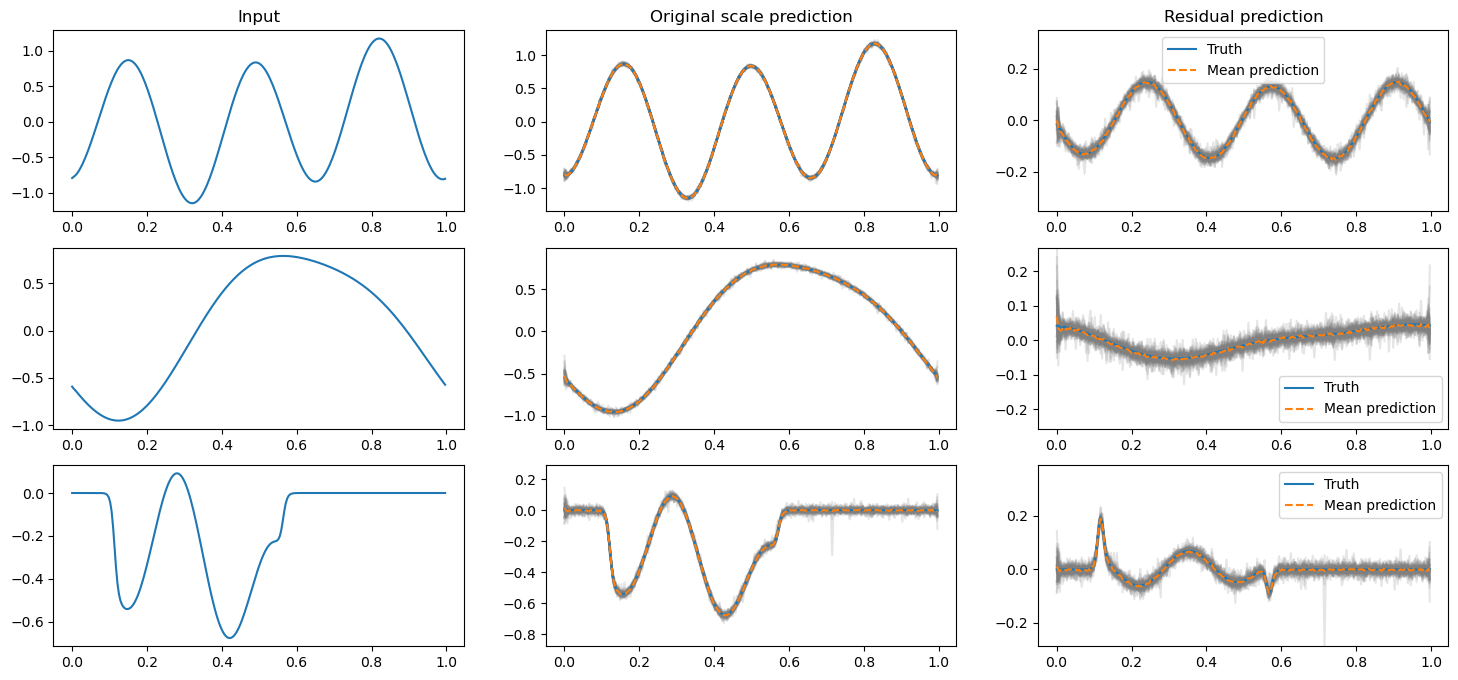

In [ ]:
plot_predictions(input, target, pred, grid)

In [ ]:
t_steps = 10
autoregressive_input = input.clone()
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)

for t in range(t_steps):
    pred = generate_diffusion_samples_low_dimensional(
        model=model,
        input = input,
        n_timesteps=50,
        target_shape=target.shape,
        n_samples=1,
        distributional_method=distributional_method,
        x_T_sampling_method=x_T_sampling_method,
        cfg_scale=cfg_scale,
        noise_schedule="linear",
    )
    if t == 0:
        pred_array[...,t] = pred.squeeze(-1) + t0
    else:
        pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

    if t == 1:
        autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
    elif t > 1:
        autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)

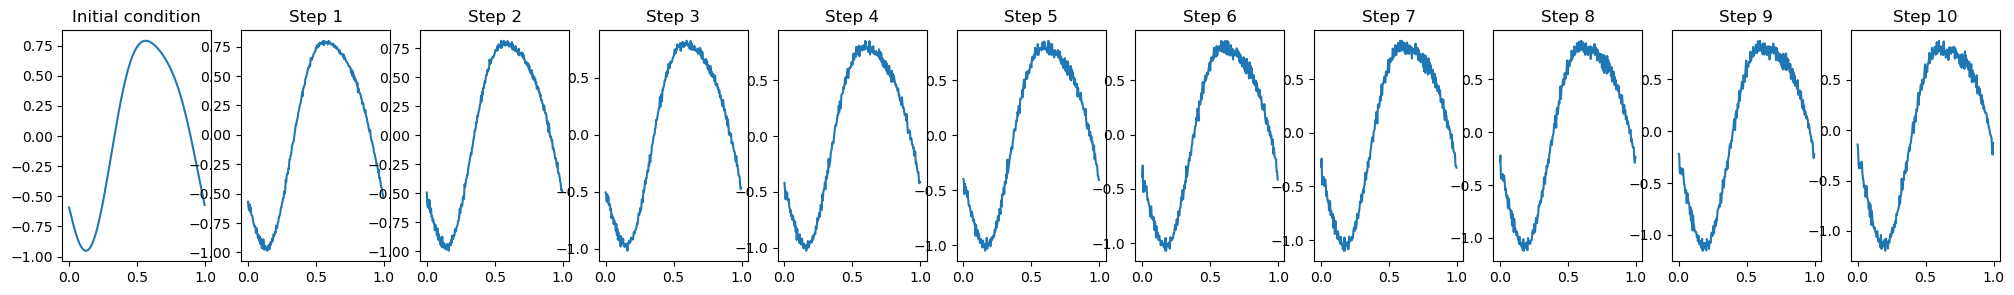

In [ ]:
# Plot the autoregressive predictions
fig, axs = plt.subplots(1, t_steps+1, figsize=(25, 3))
b = np.random.randint(3)

axs[0].plot(grid, t0[b,0].cpu().numpy())
axs[0].set_title("Initial condition")
for t in range(t_steps):
    pred_plot = pred_array[b, 0, :, t] 
    axs[t+1].plot(grid, pred_plot.cpu().numpy())
    axs[t+1].set_title(f"Step {t+1}")